<a href="https://colab.research.google.com/github/commonskubin/deep_learning_with_python/blob/main/12_3_neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
import tensorflow as tf

In [ ]:
base_image_path = keras.utils.get_file('sf.jpg', origin="https://img-datasets.s3.amazonaws.com/sf.jpg")

589824/575046 [==============================] - 0s 0us/step


In [ ]:
style_image_path = keras.utils.get_file('starry_night.jpg', origin='https://img-datasets.s3.amazonaws.com/starry_night.jpg')

958464/943128 [==============================] - 0s 0us/step


In [ ]:
original_width, original_height = keras.utils.load_img(base_image_path).size

In [ ]:
original_width

1947

In [ ]:
original_height

1460

In [ ]:
image_height = 400
image_width = round(original_width / original_height * image_height)

In [ ]:
image_width

533

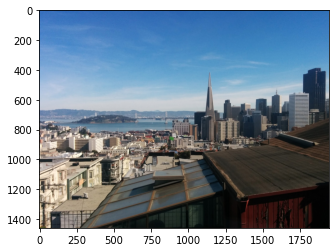

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(base_image_path)) / 255.)
plt.show()

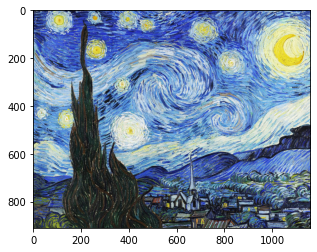

In [ ]:
plt.figure()
plt.imshow(keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(style_image_path)) / 255.)
plt.show()

In [ ]:
import numpy as np
def preprocess_img(image_path):
  img = keras.utils.load_img(image_path, target_size=(image_height, image_width))
  img = keras.utils.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = keras.applications.vgg19.preprocess_input(img)
  return img


In [ ]:
def depreocess_img(img):
  img = img.reshape((image_height, image_width, 3))
  img[:, :, 0] += 103.939
  img[:, :, 1] += 116.779
  img[:, :, 2] += 123.68
  img = img[:, :, ::-1]
  img = np.clip(img, 0, 255).astype("uint8")
  return img

In [ ]:
model = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(model.inputs, outputs=outputs_dict)
feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
def content_loss(base_img, combination_img):
  return tf.reduce_sum(tf.square(base_img - combination_img))

In [ ]:
def gram_matrix(x):
  x = tf.transpose(x, (2, 0, 1))
  features = tf.reshape(x, (tf.shape(x)[0], -1))
  gram = tf.matmul(features, tf.transpose(features))
  return gram

In [ ]:
def style_loss(style_img, combination_img):
  S = gram_matrix(style_img)
  C = gram_matrix(combination_img)
  channels = 3
  size = image_height * image_width
  return tf.reduce_sum(tf.square(S - C) / (4.0 * (channels ** 2) * (size ** 2)))


In [ ]:
def total_variation_loss(x):
  a = tf.square(
      x[:, :image_height - 1, :image_width - 1, :] - x[:, 1:, :image_width - 1, :]
  )
  b = tf.square(
      x[:, :image_height - 1, :image_width - 1, :] - x[:, :image_height - 1, 1:, :]
  )
  return tf.reduce_sum(tf.pow(a + b, 1.25))

In [ ]:
style_layers = [
  'block1_conv1',
  'block2_conv1',
  'block3_conv1',
  'block4_conv1',
  'block5_conv1',
]
content_layer_name = 'block5_conv2'
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [ ]:
def compute_loss(combination_image, base_image, style_reference_image):
  input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
  features = feature_extractor(input_tensor)
  loss = tf.zeros(shape=())
  layer_features = features[content_layer_name]
  base_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]
  loss = loss + content_weight * content_loss(base_image_features, combination_features)
  for layer in style_layers:
    layer_features = features[layer]
    style_reference_image_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += style_weight * style_loss(style_reference_image_features, combination_features) / len(style_layers)
  loss += total_variation_weight * total_variation_loss(combination_image)

  return loss


In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
  with tf.GradientTape() as tape:
    loss = compute_loss(combination_image, base_image, style_reference_image)
  grads = tape.gradient(loss, combination_image)
  return loss, grads

In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96)
)

In [1]:
base_image = preprocess_img(base_image_path)
style_image = preprocess_img(style_image_path)
combination_image = tf.Variable(preprocess_img(base_image_path))

iteration = 4000
for i in range(1, iteration + 1):
  loss, grads = compute_loss_and_grads(combination_image, base_image, style_image)
  optimizer.apply_gradients([(grads, combination_image)])
  if i % 100 == 0:
    print(f"Iteration {i}: loss={loss:.2f}")
    img = depreocess_img(combination_image.numpy())
    fname = f"combination_image_at_iteration_{i}"
    keras.utils.save_img(fname, img)

NameError: ignored